In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xf /content/drive/MyDrive/skin_cancer/final_data.tar -C /content/

In [ ]:
# HAM10000 - Stacking Ensemble (ResNet50 + ConvNeXt + EfficientNetV2-S)
# Meta Learner: XGBoost

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50, convnext, efficientnet_v2
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# PATHS
BASE_DIR = "/content/final_data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "valid/sorted")
TEST_DIR = os.path.join(BASE_DIR, "test/sorted")

MODEL_PATHS = {
    "resnet": "/content/drive/MyDrive/skin_cancer/models/resnet50_new_checkpoints/ckpt-11.keras",
    "convnext": "/content/drive/MyDrive/skin_cancer/models/convnext_tiny_checkpoints/ckpt-21.keras",
    "effv2": "/content/drive/MyDrive/skin_cancer/models/efficientnetv2_checkpoints/ckpt-22.keras"
}

# PARAMETERS
BATCH_SIZE = 32
IMG_SIZES = {
    "resnet": (224, 224),
    "convnext": (224, 224),
    "effv2": (300, 300)
}

In [ ]:
# LOAD MODELS
print("🔹 Loading trained CNN models...")
model_resnet = tf.keras.models.load_model(MODEL_PATHS["resnet"])
model_convnext = tf.keras.models.load_model(MODEL_PATHS["convnext"])
model_effv2 = tf.keras.models.load_model(MODEL_PATHS["effv2"])
print("✅ Models loaded successfully.\n")

🔹 Loading trained CNN models...
✅ Models loaded successfully.



In [ ]:
# DATA GENERATORS
def make_generator(model_name, dir_path, shuffle=False):
    preprocess_func = {
        "resnet": resnet50.preprocess_input,
        "convnext": convnext.preprocess_input,
        "effv2": efficientnet_v2.preprocess_input
    }[model_name]

    datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    gen = datagen.flow_from_directory(
        dir_path,
        target_size=IMG_SIZES[model_name],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle
    )
    return gen

val_gen_resnet = make_generator("resnet", VAL_DIR)
val_gen_convnext = make_generator("convnext", VAL_DIR)
val_gen_effv2 = make_generator("effv2", VAL_DIR)

test_gen_resnet = make_generator("resnet", TEST_DIR)
test_gen_convnext = make_generator("convnext", TEST_DIR)
test_gen_effv2 = make_generator("effv2", TEST_DIR)

Found 235 images belonging to 7 classes.
Found 235 images belonging to 7 classes.
Found 235 images belonging to 7 classes.
Found 1470 images belonging to 7 classes.
Found 1470 images belonging to 7 classes.
Found 1470 images belonging to 7 classes.


In [ ]:
# PREDICTIONS FOR META-LEARNER TRAINING (VALIDATION SET)
print("🔹 Generating validation predictions...")
pred_val_resnet = model_resnet.predict(val_gen_resnet, verbose=1)
pred_val_convnext = model_convnext.predict(val_gen_convnext, verbose=1)
pred_val_effv2 = model_effv2.predict(val_gen_effv2, verbose=1)

X_meta_train = np.concatenate([pred_val_resnet, pred_val_convnext, pred_val_effv2], axis=1)
y_meta_train = val_gen_resnet.classes

print(f"Meta-train features shape: {X_meta_train.shape}")

🔹 Generating validation predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 921ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step
Meta-train features shape: (235, 21)


In [ ]:
!pip install scikit-learn --upgrade
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 108.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1


In [ ]:
# TRAIN XGBOOST META-MODEL
print("🔹 Training XGBoost meta-learner...")

le = LabelEncoder()
y_meta_enc = le.fit_transform(y_meta_train)

xgb_meta = XGBClassifier(
    n_estimators=1600,
    learning_rate=0.012,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.75,
    min_child_weight=2,
    gamma=0.15,
    reg_alpha=1.0,
    reg_lambda=2.5,
    scale_pos_weight=3,
    eval_metric='mlogloss',
)

xgb_meta.fit(X_meta_train, y_meta_enc)
print("✅ XGBoost meta-learner trained successfully.\n")

🔹 Training XGBoost meta-learner...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:59:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost meta-learner trained successfully.



In [ ]:
# SAVE META MODEL
xgb_meta.save_model("xgb_meta.json")
print(f"💾 Meta model saved")

In [ ]:
# EVALUATE ON TEST DATA
print("🔹 Generating test predictions...")
pred_test_resnet = model_resnet.predict(test_gen_resnet, verbose=1)
pred_test_convnext = model_convnext.predict(test_gen_convnext, verbose=1)
pred_test_effv2 = model_effv2.predict(test_gen_effv2, verbose=1)

X_meta_test = np.concatenate([pred_test_resnet, pred_test_convnext, pred_test_effv2], axis=1)
y_true = test_gen_resnet.classes

🔹 Generating test predictions...
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step


In [ ]:
# Predict with XGBoost meta-learner
y_pred_meta = xgb_meta.predict(X_meta_test)

# EVALUATION METRICS
acc = accuracy_score(y_true, y_pred_meta)
f1 = f1_score(y_true, y_pred_meta, average='weighted')

print("✅ XGBoost Stacking Ensemble Results")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}\n")

✅ XGBoost Stacking Ensemble Results
Accuracy: 0.8449
Weighted F1 Score: 0.8413



Classification Report:
               precision    recall  f1-score   support

       AKIEC       0.56      0.73      0.64        30
         BCC       0.78      0.66      0.71        93
         BKL       0.79      0.72      0.75       217
          DF       0.61      0.80      0.69        25
         MEL       0.74      0.59      0.66       171
          NV       0.90      0.95      0.92       909
        VASC       0.88      0.84      0.86        25

    accuracy                           0.84      1470
   macro avg       0.75      0.76      0.75      1470
weighted avg       0.84      0.84      0.84      1470



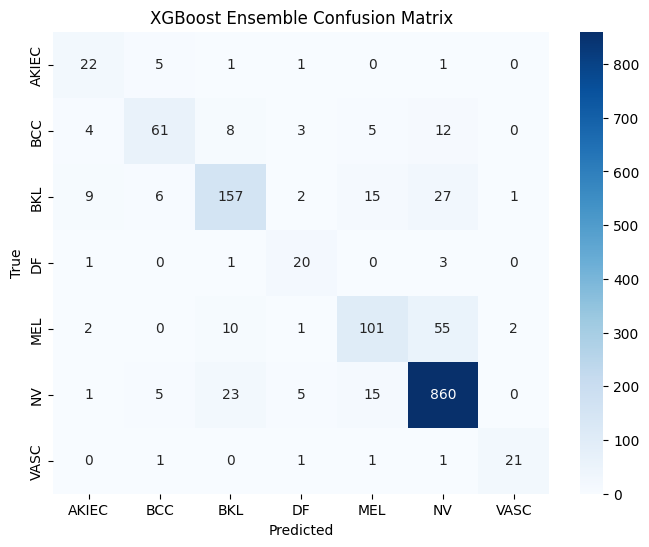


✅ Ensemble Evaluation Complete.


In [ ]:
# Classification report
class_names = list(test_gen_resnet.class_indices.keys())
report = classification_report(y_true, y_pred_meta, target_names=class_names)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_meta)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("XGBoost Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n✅ Ensemble Evaluation Complete.")

🔹 Predicting probabilities...


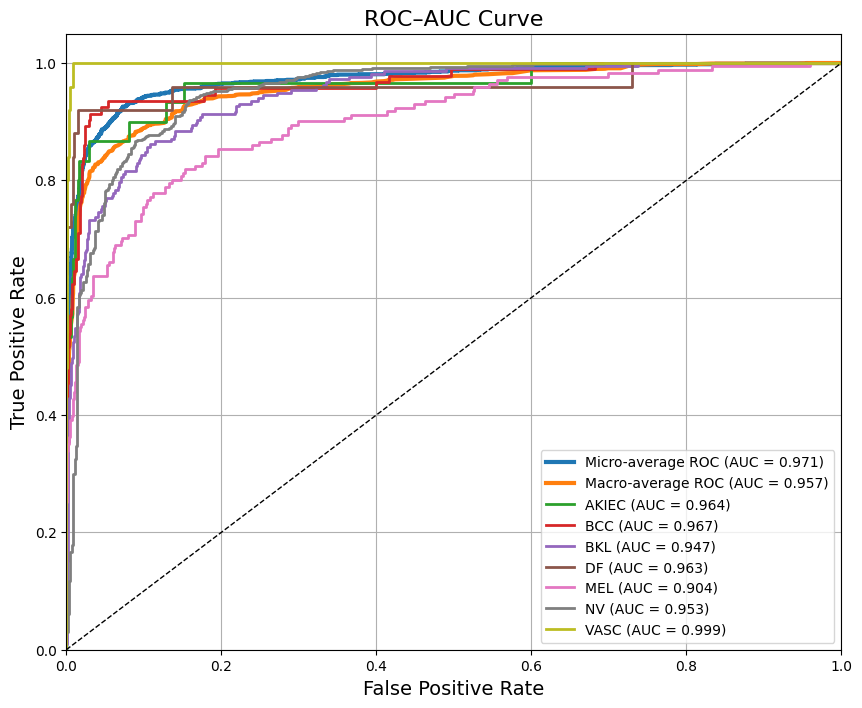

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities using XGBoost meta-learner
print("🔹 Predicting probabilities...")
y_pred_proba = xgb_meta.predict_proba(X_meta_test)

# Binarize true labels (needed for multi-class ROC)
n_classes = y_pred_proba.shape[1]
y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC Curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Micro ROC
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})",
    linewidth=3
)

# Macro ROC
plt.plot(
    all_fpr, mean_tpr,
    label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})",
    linewidth=3
)

# Per-class ROC
class_names = ["AKIEC", "BCC", "BKL", "DF", "MEL", "NV", "VASC"]

for i, cls in enumerate(class_names):
    plt.plot(
        fpr[i], tpr[i],
        label=f"{cls} (AUC = {roc_auc[i]:.3f})",
        linewidth=2
    )

# Final plot settings
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC–AUC Curve", fontsize=16)
plt.legend(loc="best", fontsize=10)
plt.grid(True)
plt.show()